# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from keras.models import load_model

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [2]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [4]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [6]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [7]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [8]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [9]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [10]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [11]:
df=np.nan_to_num(df)

In [12]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [13]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [14]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [15]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 17) (20631, 1)


In [16]:
print(max_cycles)
print(sum(max_cycles))
count = 0
for cycle_len in max_cycles:
    for i in range(11):
        y_train[count+i] = 0
    count = count + cycle_len
print(count)

[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]
20631
20631


In [17]:
print(y_train)

[[0]
 [0]
 [0]
 ...
 [3]
 [2]
 [1]]


In [18]:
def create_dataset(X, look_back=10):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)


X_train = create_dataset(X_train)
y_train = y_train[11:]

In [19]:
print(X_train.shape,y_train.shape)

(20620, 10, 17) (20620, 1)


In [20]:
print(y_train)

[[181]
 [180]
 [179]
 ...
 [  3]
 [  2]
 [  1]]


In [21]:
def build_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [22]:
model = build_model([17,10])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           74752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=75,
    validation_split=0.15,
    verbose=1)

Epoch 1/75
35/35 [==============================] - 8s 236ms/step - loss: 13745.6045 - val_loss: 16783.5469
Epoch 2/75
35/35 [==============================] - 6s 186ms/step - loss: 13180.2676 - val_loss: 15810.9551 ETA: 4s - loss: 13 - ETA:
Epoch 3/75
35/35 [==============================] - 6s 173ms/step - loss: 12035.3965 - val_loss: 14272.7705
Epoch 4/75
35/35 [==============================] - 6s 173ms/step - loss: 10458.2529 - val_loss: 12362.3252
Epoch 5/75
35/35 [==============================] - 6s 175ms/step - loss: 8698.9580 - val_loss: 10404.8213
Epoch 6/75
35/35 [==============================] - 6s 180ms/step - loss: 7059.8643 - val_loss: 8702.7285
Epoch 7/75
35/35 [==============================] - 6s 183ms/step - loss: 5703.8940 - val_loss: 6953.0112
Epoch 8/75
35/35 [==============================] - 7s 193ms/step - loss: 4090.2271 - val_loss: 5375.2939
Epoch 9/75
35/35 [==============================] - 6s 175ms/step - loss: 2985.7681 - val_loss: 4243.5898
Epoch 10/75

In [24]:
# saving model
model.save('LSTM_with_lookback_10.h5')

In [25]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


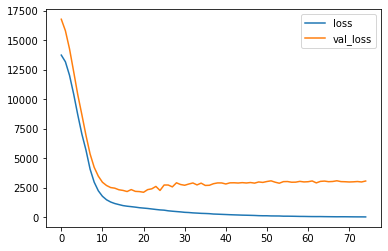

In [26]:
# Loss Graph
plt.plot(history.epoch, history.history['loss'] , label = "loss")
plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
plt.legend()
plt.show()

In [27]:
y_train_pred = model.predict(X_train)
print("mean_squared_error >> ", mean_squared_error(y_train,y_train_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train,y_train_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_train,y_train_pred))

mean_squared_error >>  496.2059910109446
root_mean_squared_error >>  22.275681605978853
mean_absolute_error >> 9.181433875199


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [5]:
model = load_model('LSTM_with_lookback_10.h5')

In [6]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [7]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [8]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles[0] = max_cycles[0] - 11

In [9]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [10]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [11]:
df_test

array([[-1.7938502 ,  1.04936462,  1.00459956, ..., -0.43585161,
        -0.26636316,  0.42059548],
       [-1.75983242, -1.22056415, -1.03515135, ...,  0.37849296,
         0.89958112,  0.64708667],
       [-1.72609272,  0.14086219,  0.34489676, ...,  0.37849296,
         1.36106152,  0.96601877],
       ...,
       [ 1.83603259, -0.26773967, -1.03515135, ...,  1.88097691,
        -1.83688403, -1.50936271],
       [ 1.84590292, -1.71931856,  0.34489676, ...,  1.88097691,
        -1.59013861, -0.80455247],
       [ 1.85572407,  0.59502963,  1.00459956, ...,  2.57907106,
        -1.33736329, -1.7132478 ]])

In [12]:
X_test = np.array(df_test)

y_test = np.array(df_rul)



# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 20  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [13]:
def create_dataset(X, look_back=10):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [14]:
X_test = create_dataset(X_test)
#y_test = y_test[6:]

In [15]:
print(X_test.shape,y_test.shape)

(13085, 10, 17) (100, 1)


In [16]:
pred = model.predict(X_test)

In [17]:
pred.shape

(13085, 1)

In [18]:
final_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i] 
    while j>0:
        temp = temp + pred[count]
        j=j-1
        count=count+1
    final_pred.append(int(temp/max_cycles[i]))

In [19]:
print(final_pred)

[136, 161, 73, 102, 105, 101, 115, 81, 90, 112, 49, 114, 114, 51, 188, 134, 52, 63, 131, 69, 100, 150, 146, 73, 112, 105, 115, 76, 126, 88, 46, 66, 64, 85, 45, 31, 110, 39, 112, 46, 99, 87, 76, 124, 81, 59, 30, 115, 105, 123, 93, 123, 96, 145, 150, 21, 80, 72, 120, 97, 63, 128, 87, 86, 87, 59, 109, 99, 115, 89, 75, 92, 114, 96, 121, 90, 68, 129, 104, 81, 46, 61, 109, 92, 87, 97, 137, 84, 84, 83, 32, 36, 64, 84, 107, 82, 67, 89, 138, 111]


In [20]:
final_pred[0]

136

## Using last index as prediction

In [23]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

[120, 88, 20, 68, 35, 53, 103, 31, 53, 60, 27, 83, 105, 28, 203, 127, 23, 53, 151, 0, 48, 173, 98, 2, 135, 57, 51, 50, 56, 46, 0, 29, 57, 0, 0, 0, 20, 13, 132, 0, 21, 1, 34, 138, 34, 17, 36, 69, 0, 72, 46, 11, 7, 132, 108, 0, 25, 22, 78, 80, 12, 46, 35, 10, 98, 0, 153, 0, 109, 48, 56, 37, 70, 55, 139, 0, 12, 125, 49, 65, 0, 0, 126, 38, 117, 60, 112, 39, 40, 9, 0, 0, 13, 20, 55, 87, 62, 54, 93, 2]


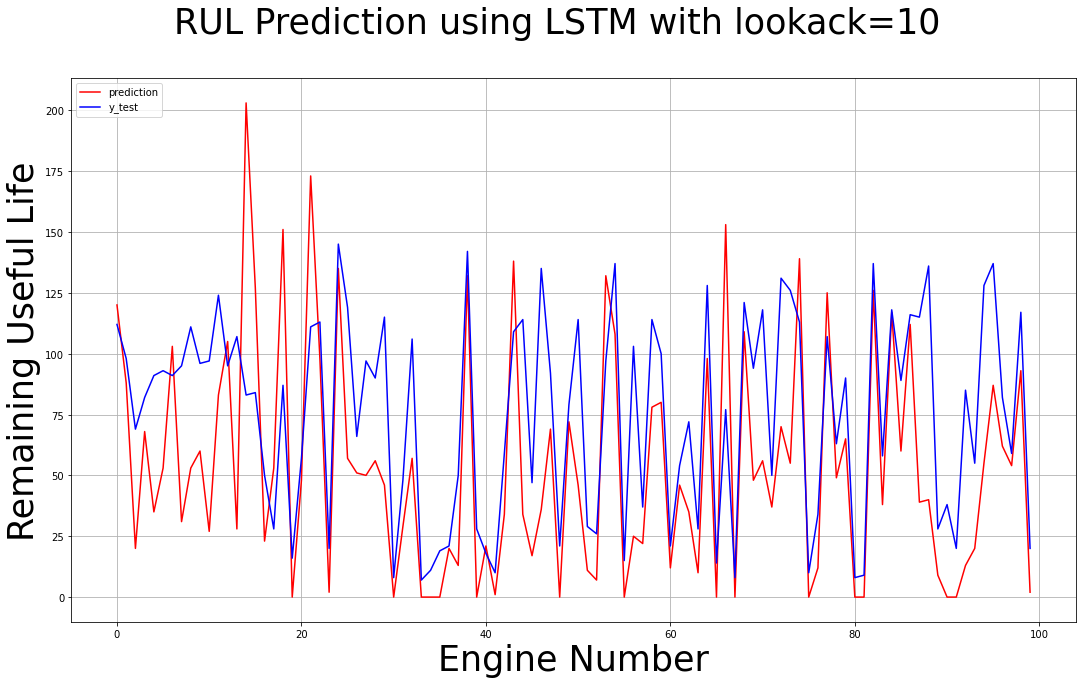

mean_squared_error >>  1694.33
root_mean_squared_error >>  41.16223997792151
mean_absolute_error >> 32.39
scoring functon >> 173798.2339902401


In [24]:
final_pred = []
count = 0
for i in range(100):
    j = max_cycles[i] 
    temp = pred[count+j-1]
    count=count+j
    final_pred.append(int(temp))

print(final_pred)


fig = plt.figure(figsize=(18,10))
plt.plot(final_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using LSTM with lookack=10', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,final_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,final_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,final_pred))
print("scoring functon >>",scoring_function(y_test,final_pred))